<a href="https://colab.research.google.com/github/SaumilShah-7/Dog-Breed-Identification-Kaggle/blob/master/Dog_Breed_Identification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from zipfile import ZipFile
import cv2

TensorFlow 2.x selected.
2.0.0-rc2


In [3]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (3).json


In [4]:
!kaggle competitions download -c dog-breed-identification

labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
with ZipFile('train.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('test.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('sample_submission.csv.zip', 'r') as zipobj:
  zipobj.extractall()

In [0]:
y_df = pd.read_csv('labels.csv')

# print(y_df['breed'].value_counts())

y_breed = np.asarray(y_df['breed']).reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y_breed)

labels_mapping = {np.argmax(y[i]): y_df.loc[i,'breed'] for i in range(len(y))}

image_height = 128
image_width = 128

x = []
for i in y_df['id']:
  image = cv2.imread('/content/train/'+i+'.jpg')
  x.append(cv2.resize(image, (image_height, image_width)))
x = np.asarray(x)

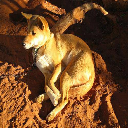

(128, 128, 3) ['dingo']


In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(x[1])
print(x[1].shape, y_breed[1])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7155, 128, 128, 3) (3067, 128, 128, 3) (7155, 120) (3067, 120)


In [0]:
mean = np.mean(x_train, axis=0)
std_dev = np.std(x_train, axis=0)

x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

x_train-=mean
x_train/=std_dev

x_test-=mean
x_test/=std_dev

In [0]:
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
                             horizontal_flip=True, fill_mode="nearest")

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(image_width, image_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(units=500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=120, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
143/143 [============================>.] - ETA: 0s - loss: 4.8077 - accuracy: 0.0132
Epoch 00001: val_accuracy improved from -inf to 0.01239, saving model to best_model.h5
144/143 [==============================] - 40s 281ms/step - loss: 4.8072 - accuracy: 0.0133 - val_loss: 4.7507 - val_accuracy: 0.0124
Epoch 2/100
143/143 [============================>.] - ETA: 0s - loss: 4.7191 - accuracy: 0.0201
Epoch 00002: val_accuracy improved from 0.01239 to 0.02022, saving model to best_model.h5
144/143 [==============================] - 38s 261ms/step - loss: 4.7189 - accuracy: 0.0200 - val_loss: 4.6418 - val_accuracy: 0.0202
Epoch 3/100
143/143 [============================>.] - ETA: 0s - loss: 4.6392 - accuracy: 0.0239
Epoch 00003: val_accuracy improved from 0.02022 to 0.03097, saving model to best_model.h5
144/143 [==============================] - 38s 262ms/step - loss: 4.6399 - accur

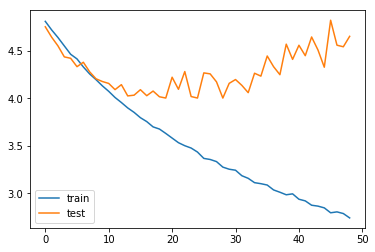

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

bs = 50

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=bs), validation_data=(x_test, y_test), 
                              steps_per_epoch=len(x_train)/bs, epochs=100, callbacks=[es, mc])
saved_model = load_model('best_model.h5')

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()